\begin{equation} \label{eq1}
\begin{split}
 \mathbb{R} & = C_{00} P_p  \int_{z_0} p_{r|H_0}(R|H_0)dR \\
 & + C_{10} P_p  \int_{z_1} p_{r|H_0}(R|H_0)dR
\end{split}
\end{equation}

In [1]:
import torch
import numpy as np
from matplotlib import pyplot as plt
import scipy
%matplotlib inline


# MAP Threshold 
$H_1: r = 1 + n$\
$H_0: r = n$\
where $n$ is additive Gaussian Noise with $R(\tau)=\sigma^2\delta(\tau)\tag{1}$ and $\sigma^2 = \frac{N_0}{2}$. MAP decision will be defined as 

\begin{equation*}
\frac{p_{r | H_1}(r | H_1)}{p_{r | H_0}(r | H_0)} \underset{H_0}{\overset{H_1}{\gtrless}} \frac{p(H_0)}{p(H_1)}
\end{equation*}

where 
\begin{equation*}
p_{r | H_1}(r | H_1)= {\frac {1}{\sqrt{\frac{N_0}{2}{2\pi} }}}e^{-{\frac {1}{2}}\left((r-1 )/\frac{N_0}{2} \right)^{2}}
\end{equation*}
\begin{equation*}
p_{r | H_0}(r | H_0)= {\frac {1}{\sqrt{\frac{N_0}{2}{2\pi} }}}e^{-{\frac {1}{2}}\left((r )/\frac{N_0}{2} \right)^{2}}
\end{equation*}
and $p(H_0) = 1/3$ and $p(H_1) = 2/3$ is given in question. If we define likelihood ratio and threshold as
\begin{equation*}
 \Lambda(r) = \frac{p_{r | H_1}(r | H_1)}{p_{r | H_0}(r | H_0)} \\
\end{equation*}
and
\begin{equation*}
\xi = \frac{p(H_0)}{p(H_1)} = 1/2
\end{equation*}



 and apply logaritmic transformation to make the division easy for exponentials, we get
\begin{equation*}
ln \Lambda(r) = \frac{2}{N_0}r - \frac{1}{N_0}
\end{equation*}
and threshold directly affecting observation (single observation) becomes
\begin{equation*}
r \underset{H_1}{\overset{H_2}{\gtrless}} \frac{N_0}{2} ln (\xi) + 1/2
\end{equation*}
and numerical threshold for each observation can be calculated and it depends AWGN on channel directly.

In [2]:
def define_threshold(noise): #N0_2 in linear 
    return noise * np.log(1/2) + 1/2
def db2linear(value):
    return 10 ** (value/10) 

In [12]:
#I created noise in linear, not dB
db_noise = np.linspace(0,-10,5)
db_noise

array([  0. ,  -2.5,  -5. ,  -7.5, -10. ])

# Decision Rules with Given Noise
## Given assignment suggests that try out 3 things:
1 - AND Gate in k digits\
2 - OR Gate in k digits\
3 - Choose according to M-of-k digits

Actually, these suggestions are simply one rule with parameter M. If M = k-1, it is AND gate, if M = 0, it is OR gate. I wrote function that accepts M as a parameter as well. And tried it between 0 and k-1.

In [9]:
def gate_decision(noise, M, k=10, sequence_length = 10000):
    error = 0
    count = 0
    while error < 100:
            #Threshold for given noise
        count += 1
        threshold = define_threshold(db2linear(noise))
            #Sequence generating
        random_sequence = torch.rand(1,sequence_length)[0]
        ones_zeros = (random_sequence > 1/3).float()
            #Repeating each bit k times
        ones_zeros.repeat(k, 1)
        noise_signal = torch.rand(k, sequence_length) * torch.sqrt(torch.tensor(db2linear(noise)))
        reciever = noise_signal + ones_zeros
        sequence_recieved = torch.sum((reciever > threshold).float(),dim=0) > M
        error += torch.sum(sequence_recieved.float() - ones_zeros)
#         print(f"error sayisi:{error}, count: {count}")
        

    bit_error_rate = error / (count * sequence_length)
    
    return bit_error_rate

In [ ]:
BER = []
BER_m = []
for m in range(0,10):
    for noise in db_noise:
        BER.append(gate_decision(noise, M = m).data.numpy())
    BER_m.append(np.array(BER))
    BER = []
    

In [13]:
BER_m

[array([0.3241, 0.3336, 0.3318, 0.3358, 0.3256, 0.328 , 0.3331, 0.3371,
        0.3296, 0.3311], dtype=float32),
 array([0.3337, 0.3445, 0.3396, 0.3348, 0.3371, 0.3235, 0.3363, 0.3332,
        0.3173, 0.3083], dtype=float32),
 array([0.33  , 0.339 , 0.3336, 0.3346, 0.3352, 0.3334, 0.3358, 0.3219,
        0.3097, 0.2425], dtype=float32),
 array([0.3358, 0.3357, 0.3368, 0.3332, 0.3293, 0.3392, 0.3198, 0.3068,
        0.244 , 0.1628], dtype=float32),
 array([0.327 , 0.3359, 0.3415, 0.3256, 0.3347, 0.3215, 0.3018, 0.251 ,
        0.1675, 0.0872], dtype=float32),
 array([0.3347, 0.3249, 0.3376, 0.3381, 0.3384, 0.3069, 0.2538, 0.1685,
        0.0907, 0.0326], dtype=float32),
 array([0.3373  , 0.327   , 0.3404  , 0.3314  , 0.3097  , 0.249   ,
        0.1662  , 0.0844  , 0.0345  , 0.008575], dtype=float32),
 array([0.329     , 0.3261    , 0.3353    , 0.3189    , 0.2556    ,
        0.1693    , 0.0822    , 0.0301    , 0.0095    , 0.00146667],
       dtype=float32),
 array([3.4380001e-01, 3.3210

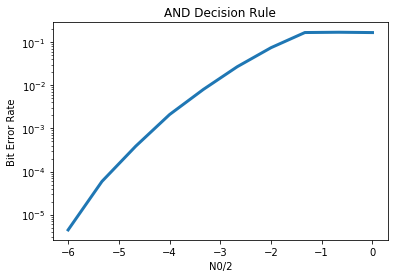

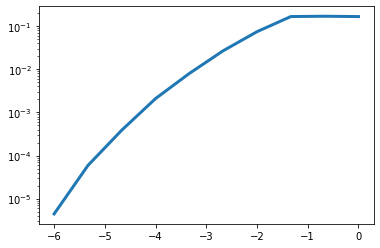

In [469]:
plt.subplot(1,1,1)
plt.plot(db_noise, np.array(BER_and), lw=3)
plt.yscale('log')
plt.xlabel("N0/2")
plt.ylabel("Bit Error Rate")
plt.title("AND Decision Rule")
plt.show()
plt.subplot(1,1,1)
plt.plot(db_noise, np.array(BER_and), lw=3)
plt.yscale('log')
plt.show()

In [299]:
sequence_recieved

tensor([1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1],
       dtype=torch.uint8)